<a href="https://colab.research.google.com/github/MiguelAngeloTr/BIGDATA/blob/main/C2/P2/Parcial_2_BIGDATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Universidad Autónoma de Occidente

##Facultad de Ingenierías y Ciencias Básicas

##Curso: Big Data

##Profesor: Juan Sebastian Mosquera

##Correo: smosquera@uao.edu.co

---

### **NOMBRE COMPLETO:**

###**CODIGO:**

### **PROGRAMA:**

---

### **Condiciones**

*   Pueden usar los archivos Google Colab trabajados en clase.
*   Utilizar PySpark para el procesamiento de datos y aplicación de la tarea de ML, para gráficos pueden migrar a pandas unicamente las variables seleccionadas.
*   No pueden usar IA para buscar las respuetas del examen. Quien sea visto en flagrancia, el examen será **anulado**.
*   Pueden usar el material de referencia de UAO virtual
*   Subir el archivo con extensión .ipynb a la plataforma antes de las 11:59 PM.

# **Examen 2**

Se presentan dos conjuntos de datos con multiples características. Se requiere llevar a cabo una tarea de regresión y una de clasificación con cada uno de ellos, es decir, deberá elegir que tarea resolver para el primer dataset y realizar la otra tarea para el segundo.

## **Dataset 1**

El conjunto de datos es el resultado de un análisis de la estabilidad local de un sistema en estrella de 4 nodos (el productor de electricidad está en el centro) aplicando el concepto de control descentralizado de una red inteligente.

Este conjunto comprende 10.000 registros, que permiten determinar la estabilidad del sistema

- tau[x]: reaction time of participant (real from the range [0.5,10]s). Tau1 - the value for electricity producer.
- p[x]: nominal power consumed(negative)/produced(positive)(real). For consumers from the range [-0.5,-2]s^-2; p1 = abs(p2 + p3 + p4)
- g[x]: coefficient (gamma) proportional to price elasticity (real from the range [0.05,1]s^-1). g1 - the value for electricity producer.
- **stab:** the maximal real part of the characteristic equation root (if positive - the system is linearly unstable)(real)
- **stabf:** the stability label of the system (categorical: stable/unstable)

## **Dataset 2**

El conjunto de datos continee datos provenientes de un acelerómetro de las vibraciones de un ventilador con pesos en sus aspas.

Para generar vibraciones se utilizó un ventilador con pesas en las aspas. A este ventilador se le acopló un acelerómetro para recoger los datos de las vibraciones. Con estos datos, se hicieron predicciones del tiempo de fallo del motor, utilizando una red neuronal artificial. Para generar tres escenarios de vibración distintos, los pesos se distribuyeron de tres maneras diferentes: 1) «rojo» - configuración normal: dos piezas de peso colocadas en palas vecinas; 2) “azul” - configuración perpendicular: dos piezas de peso colocadas en palas que forman un ángulo de 90°; 3) «verde» - configuración opuesta: dos piezas de peso colocadas en palas opuestas.

Se establecieron 17 velocidades de rotación, entre el 20% y el 100% de la velocidad máxima del ventilador a intervalos del 5%; para las tres configuraciones de distribución de pesos en las palas del ventilador.

Las mediciones de vibración se recogieron a una frecuencia de 20 ms durante 1 min para cada porcentaje, generando 3000 registros por velocidad. Así, en total, se recogieron 153.000 registros de vibración del modelo de simulación.

Las variables registradas son las siguientes:

- **wconfid:** Weight Configuration ID (1 - 'red' - normal configuration; 2 - 'blue' - perpendicular configuration; 3 - 'green' - opposite configuration)
- **pctid:** Cooler Fan RPM Speed Percentage ID (20 means 20%, and so on).
- x: Accelerometer x value.
- y: Accelerometer y value.
- z: Accelerometer z value.

### Realice el ajuste a los modelo de ML seleccionados teniendo en cuenta todo el flujo de trabajo visto en clase:

* Preprocesado de datos (Vacios, columnas innecesarias, entre otros)
* Analisis Exploratorio de Datos (Bien realizada y con escritos apoyados en datos de que sucede en este dataset)
* Seleccion de Características (al menos deben ser 2, maximo las que consideren necesarias. Todo debidamente soportado)
* Encoding de variables categoricas si aplica.
* Entrenamiento del Modelo
* Validación del Modelo

Finalmente se esperan conclusiones sobre el modelo, donde determinen si los resultados son confiables o no.

In [1]:


!pip install -q pyspark
!pip install -q findspark


In [6]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.window as W
import pyspark.sql.types as T
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.core.dtypes.api import is_numeric_dtype, is_string_dtype
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression
from mlxtend.plotting import plot_confusion_matrix #falsos positivos falsos negativos
from mlxtend.evaluate import confusion_matrix
from yellowbrick.classifier import ROCAUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [3]:
spark = SparkSession.builder.appName("AED PySpark").getOrCreate()
spark


In [4]:
#cargar dataset1

import requests
path = "https://raw.githubusercontent.com/MiguelAngeloTr/BIGDATA/refs/heads/main/C2/P2/dataset1.csv"
req = requests.get(path)
url_content = req.content

csv_file_name = 'dataset1.csv'
csv_file = open(csv_file_name, 'wb')

csv_file.write(url_content)
csv_file.close()



#cargar dataset2

import requests
path = "https://raw.githubusercontent.com/MiguelAngeloTr/BIGDATA/refs/heads/main/C2/P2/dataset2.csv"
req = requests.get(path)
url_content = req.content

csv_file_name = 'dataset2.csv'
csv_file = open(csv_file_name, 'wb')

csv_file.write(url_content)
csv_file.close()

In [5]:
df1 = spark.read.csv('/content/dataset1.csv', header=True, inferSchema=True)
print('Shape of the dataset: ', (df1.count(), len(df1.columns)))
df1.show(n=10)
df2 = spark.read.csv('/content/dataset2.csv', header=True, inferSchema=True)
print('Shape of the dataset: ', (df2.count(), len(df2.columns)))
df2.show(n=10)

Shape of the dataset:  (10000, 14)
+-----------------+----------------+----------------+----------------+----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+--------------------+--------+
|             tau1|            tau2|            tau3|            tau4|              p1|                p2|                p3|                p4|               g1|                g2|               g3|               g4|                stab|   stabf|
+-----------------+----------------+----------------+----------------+----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+--------------------+--------+
| 2.95906002455997|3.07988520422811|8.38102539191882|9.78075443222607|3.76308477206316|-0.782603630987543| -1.25739482958732|  -1.7230863114883|0.650456460887227| 0.859578105752345|0.887444920638513|0.958033987602737|  0.

Datos faltantes

In [8]:

def faltantes(df):
  falta = df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in df.columns])
  return falta.show()



In [10]:
faltantes(df1)

+----+----+----+----+---+---+---+---+---+---+---+---+----+-----+
|tau1|tau2|tau3|tau4| p1| p2| p3| p4| g1| g2| g3| g4|stab|stabf|
+----+----+----+----+---+---+---+---+---+---+---+---+----+-----+
|   0|   0|   0|   0|  0|  0|  0|  0|  0|  0|  0|  0|   0|    0|
+----+----+----+----+---+---+---+---+---+---+---+---+----+-----+



In [11]:
faltantes(df2)

+-------+-----+---+---+---+
|wconfid|pctid|  x|  y|  z|
+-------+-----+---+---+---+
|      0|    0|  0|  0|  0|
+-------+-----+---+---+---+



ANALISIS EXPLORATORIO

In [12]:
numeric_features = [t[0] for t in df1.dtypes if t[1] == 'int' or t[1] == 'double']
df1.select(numeric_features).describe().toPandas().transpose()

0                    1                     2  \
summary  count                 mean                stddev   
tau1     10000    5.249999930614209    2.7425483741341647   
tau2     10000    5.250001022042511    2.7425486737170175   
tau3     10000   5.2500035241544225    2.7425494575854055   
tau4     10000    5.249997064361223    2.7425555299775657   
p1       10000   3.7499999579361503    0.7521601049043652   
p2       10000  -1.2500004574399335   0.43303484993229047   
p3       10000   -1.249999744447177    0.4330350963379907   
p4       10000  -1.2499997560490506   0.43303499416424773   
g1       10000   0.5249997888492062   0.27425553195105695   
g2       10000   0.5250002583737613    0.2742549034457489   
g3       10000   0.5250003398008583    0.2742548130390355   
g4       10000   0.5250000906280391    0.2742548446656047   
stab     10000  0.01573090000276595  0.036919032366737985   

                           3                   4  
summary                  min                 max  
tau1       0.500793021360319    9.99946946943287  
tau2       0.500141360493773    9.99983655621537  
tau3       0.500788152733829    9.99945000849598  
tau4       0.500472961226082    9.99944329731088  
p1          1.58258966481528     5.8644179596283  
p2         -1.99989095591106  -0.500108275885764  
p3         -1.99994466917731   -0.50007225154374  
p4         -1.99992633173043  -0.500024528740323  
g1        0.0500093036111293   0.999937073063054  
g2        0.0500531010350864   0.999944294487435  
g3        0.0500536923673214   0.999981832400081  
g4        0.0500284939589759   0.999930047985306  
stab     -0.0807598924160244   0.109403206284885

In [14]:
numeric_features2 = [t[0] for t in df2.dtypes if t[1] == 'int' or t[1] == 'double']
df2.select(numeric_features2).describe().toPandas().transpose()

0                     1                   2       3      4
summary   count                  mean              stddev     min    max
wconfid  153000                   2.0  0.8164992492302979       1      3
pctid    153000                  60.0   24.49497747690858      20    100
x        153000    0.9956221764704318  0.7739583180735674    -8.0  7.996
y        153000  0.005351339869281116  0.7426016980154824    -8.0  7.996
z        153000  -0.11776916339868901  0.5170078225119651  -5.867  6.086

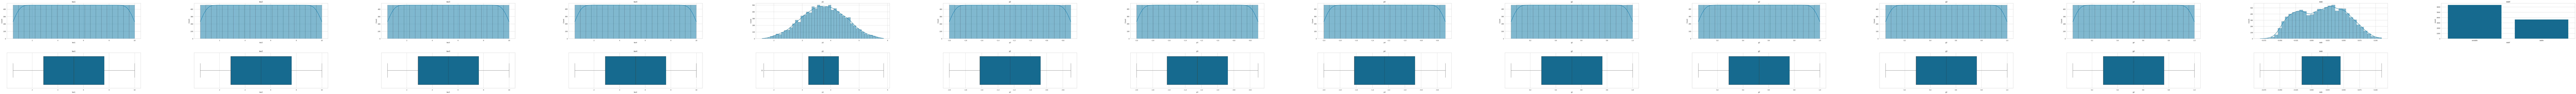

In [15]:
datos_EDA = df1.toPandas()
num_list = []
cat_list = []

fig, axes = plt.subplots(2, len(datos_EDA.columns), figsize=(300, 10))  # Ajusta el tamaño según sea necesario
fig.subplots_adjust(hspace=0.4, wspace=0.4)

axes = axes.flatten()

# Contador para los gráficos
graph_count = 0

# Iterar sobre las columnas del DataFrame
for column in datos_EDA.columns:
    if is_numeric_dtype(datos_EDA[column]):
        # Histograma en la primera fila
        sns.histplot(datos_EDA[column], kde=True, ax=axes[graph_count])
        axes[graph_count].set_title(f"{column}")

        # Boxplot en la segunda fila
        sns.boxplot(x=datos_EDA[column], ax=axes[graph_count + len(datos_EDA.columns)])
        axes[graph_count + len(datos_EDA.columns)].set_title(f"{column}")
        num_list.append(column)
        graph_count += 1  # Pasar al siguiente gráfico

    elif is_string_dtype(datos_EDA[column]):
        sns.countplot(data=datos_EDA, x=datos_EDA[column], ax=axes[graph_count])
        axes[graph_count].set_title(f"{column}")
        cat_list.append(column)
        axes[graph_count + len(datos_EDA.columns)].axis("off")
        graph_count += 1  # Pasar al siguiente gráfico

# Mostrar la gráfica
plt.show()


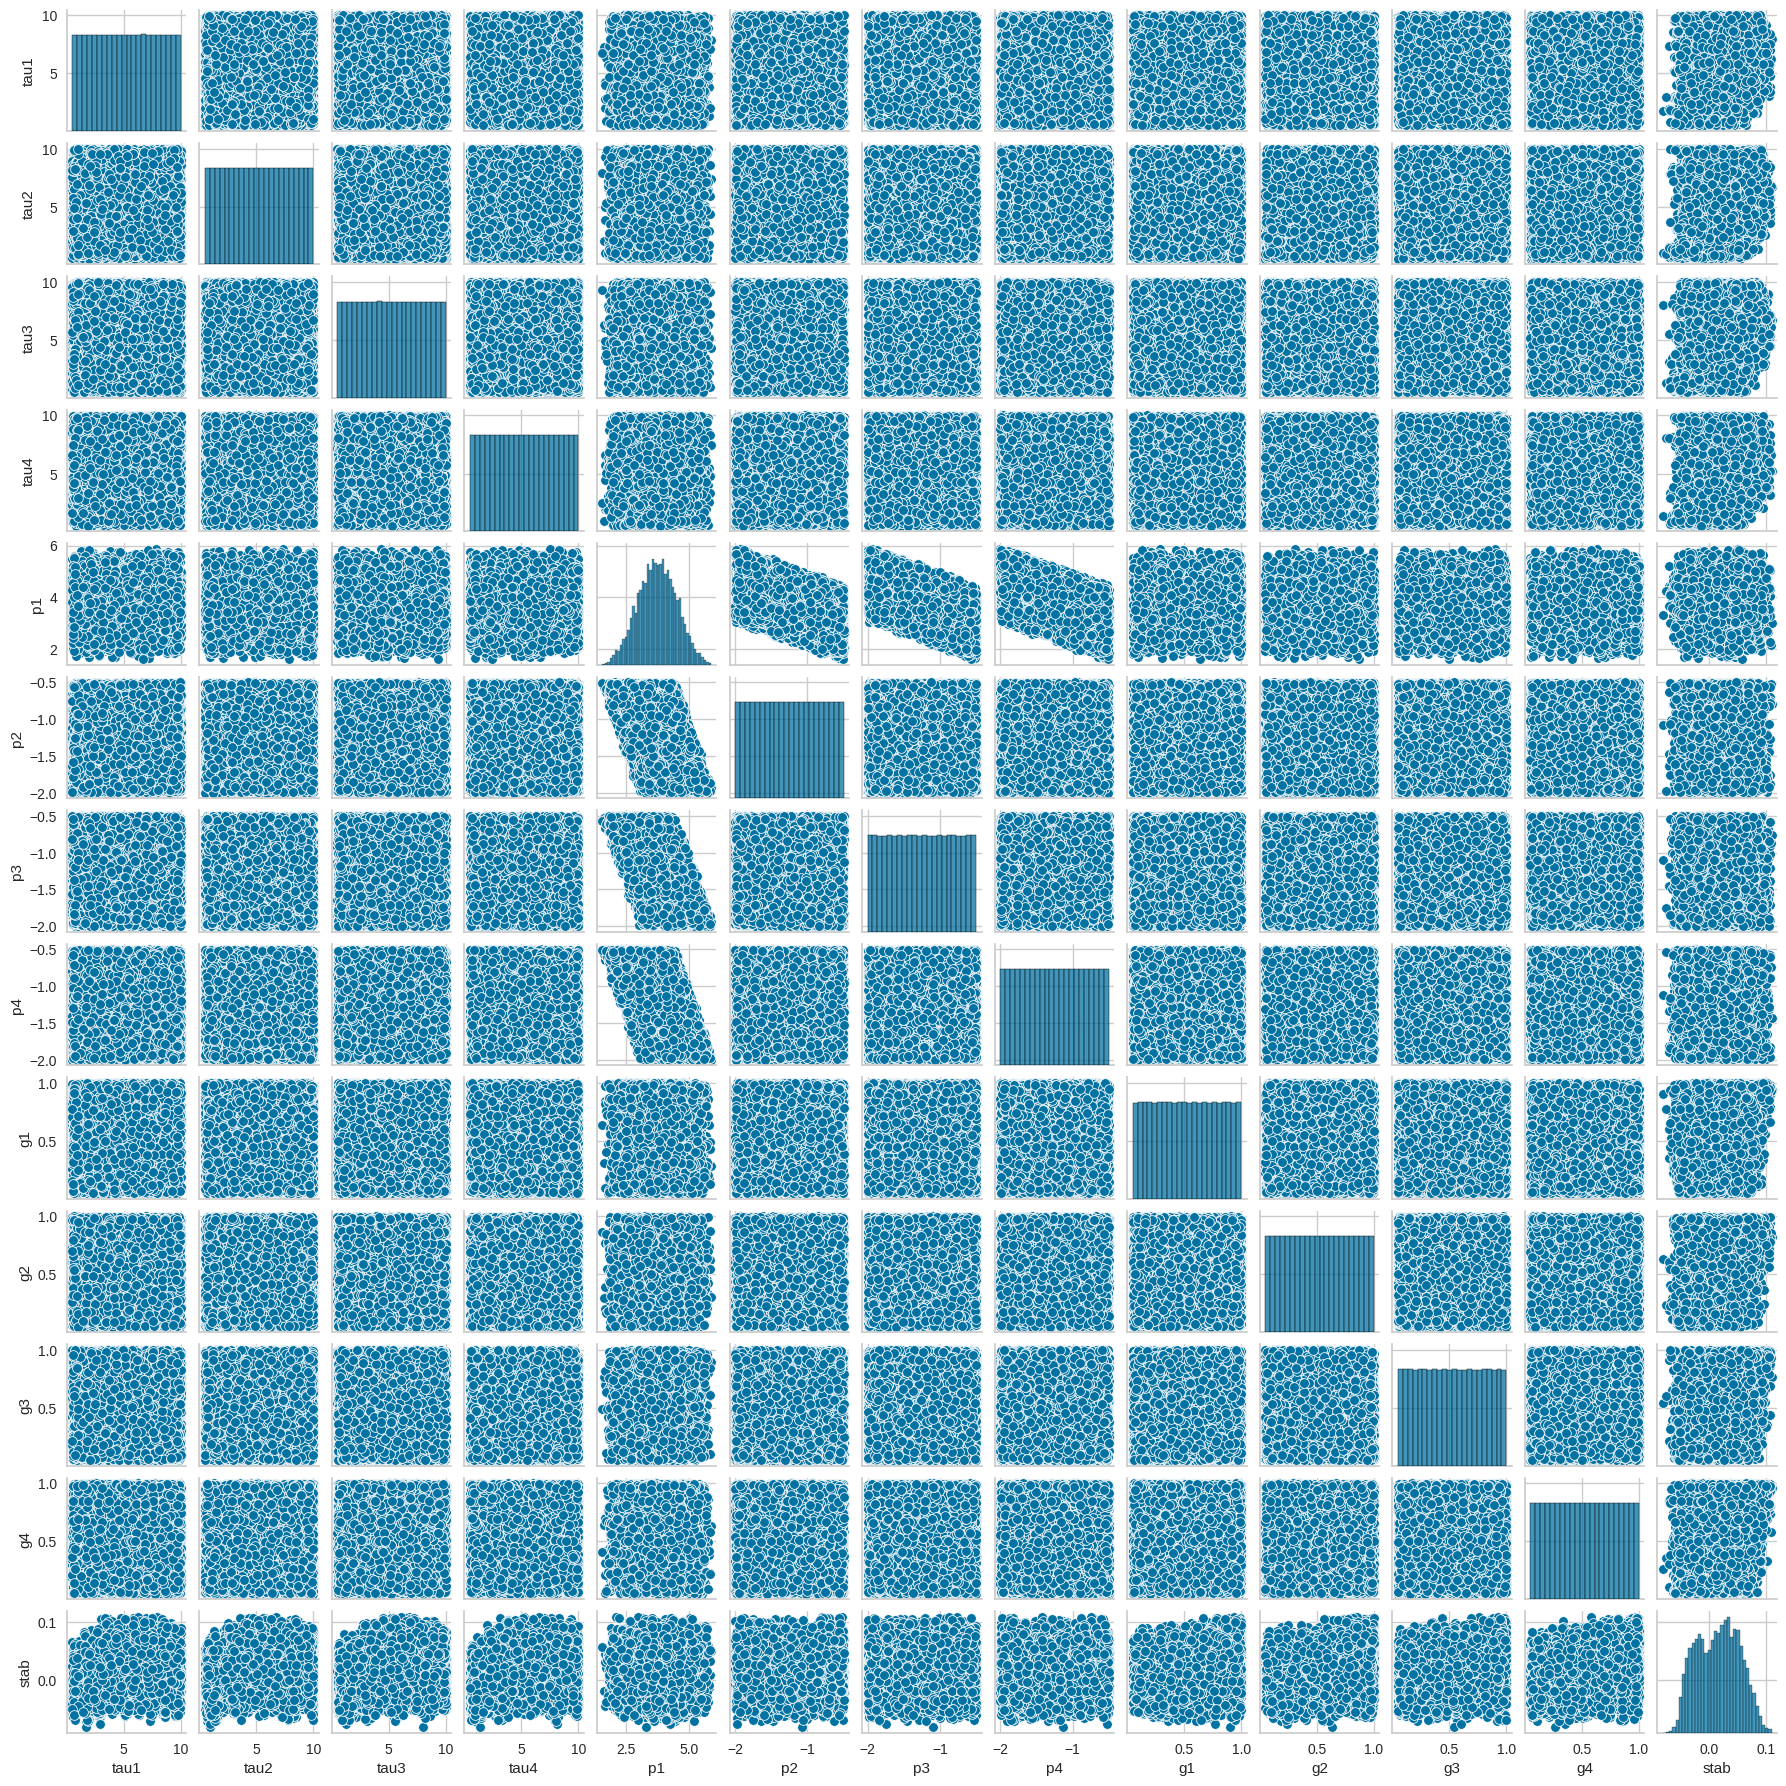

In [17]:
numeric_data = df1.select(numeric_features).toPandas()
sns.pairplot(numeric_data, height=1.4)
plt.show()


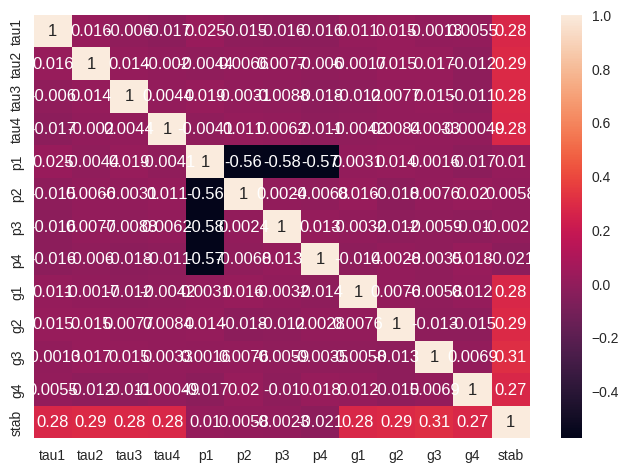

In [18]:

sns.heatmap(numeric_data.corr('spearman'),annot=True)
plt.show()

# Clasificación


#Regresión